# Notebook for simulating and plotting spikes

This notebook is a quick introduction on how to **create**, **use**, and **analyse** neuron activity. Specifically you will learn how to simulate single neurons and plot their spikes. 

We focus on understandability, not efficiency, so note that the code could be much more efficient.

First of all we need to install some prerequisites:

In [1]:
!pip install -q matplotlib numpy scipy tqdm

You should consider upgrading via the '/home/jens/.venvs/norse/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install -qU git+https://github.com/norse/norse

You should consider upgrading via the '/home/jens/.venvs/norse/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import torch          # PyTorch
import numpy as np    # Numpy

# Import a simple LIF feedforward cell (no backpropagation or learning for now)
from norse.torch.module.lif import LIFFeedForwardCell

## Creating 10 leaky integrate-and-fire (LIF) neurons

To start simulating we need `10` neurons. Each neuron needs to be set to a default state (`lif_state`). This default state tells us what the initial neuron parameters are (for now, we are just using the defaults), how many batches we have (`1`, so none), and what device we will use to simulate our neuron on (`cpu`).

The neurons will receive currents as inputs, and produce spikes as outputs. Note that the `lif_state` duplicates the `0` initial state value to all `10` neurons. That will be important later.

In [4]:
# Creates a LIF population of 10 cells
lif_cell = LIFFeedForwardCell([10])
# Set the initial state to 0, running on a CPU
lif_state = lif_cell.initial_state(batch_size=1, device="cpu")

## Creating data for the 10 neurons

To illustrate how a LIF neuron works, we wil simulate 100 timesteps. Each of the 10 neurons (indexed from 0 to 9) will receive the same input at every timestep. In the setup below, the input voltages follow the formula $i_n * 0.2$, where $i_n$ is the neuron index. Meaning, neuron 0 will receive an input of 0 for each timestep, so we do not expect that to spike. Neuron 1 will receive 0.2, so that *could* be enough for it to spike. Neuron 9 will receive an input of 1.80 every timestep, so we expect that to spike quite a few times.

In [5]:
# We are simulating 100 timesteps
timesteps = 100
# Create one current for each neuron (first neuron = 0, second neuron = 0.2, etc.)
neuron_currents = torch.tensor([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
# Duplicate the neuron currents 100 times (timesteps)
population_currents = neuron_currents.repeat(100, 1)
# We now have 100 timesteps of unique currents for each of the 10 neurons
population_currents.shape

torch.Size([100, 10])

## Running the simulation

To run the simulation, we prepare a list of spikes and a state-variable, where the neuron states will be updated in. Remember that the `lif_state` variable contains 10 separate states - one for each neuron. This will be important, because we are giving each neuron a different input current each timestep. During the simulation, the states will update independently, resulting in different behaviours.

In [6]:
spikes = []       # Prepare list for spike data
state = lif_state # Set initial state

# Loop over all the 
for data in population_currents:
    # Inject the current and the current state into the neuron
    # Returns the spikes that occurred during that timestep + the new neuron state
    out, state = lif_cell(data, state)
    # Take the spikes from the first batch (since we are not yet using batches)
    batch_data = out[0]
    # Add that to our list of spike outputs
    spikes.append(np.array(batch_data))

# Convert the spike list to a Numpy array
spikes = np.array(spikes) 

We now have the spike data as a list of outputs for each timestep. Let's see how it looks at timestep 100:

In [7]:
spikes[99]

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)

The data tells us that at timestep 100, neuron 5 and 7 emitted a spike.

## Plotting the spikes

There are likely many more spikes, but it's too much work to go through the array one timestep at the time. A spike plot is much better suited to give us an overview.

First, we import matplotlib.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Basically, we want to show the timesteps on the x axis and the neuron index on the y axis. Spikes will then be shown as a tuple of (timestep, neuron_index). If there are no spike, we don't have to show anything. 

Matplotlib's [`.eventplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.eventplot.html?highlight=eventplot#matplotlib.pyplot.eventplot) is perfect for this. We just have to condense our spikes into a list of neurons, containing the timesteps that it fires. So, for neuron 0 that list will be empty, and for neuron 9 we will have a lot of spikes. The below code arranges that data, and we can see that neuron 5 still fires at timestep 99:

In [9]:
spike_data = [[x for x, spike in enumerate(inner_spikes) if spike > 0] for inner_spikes in spikes.T]
spike_data[5][-1] # Output the last spike from neuron number 9

99

We are finally ready to plot each neuron starting from 0.

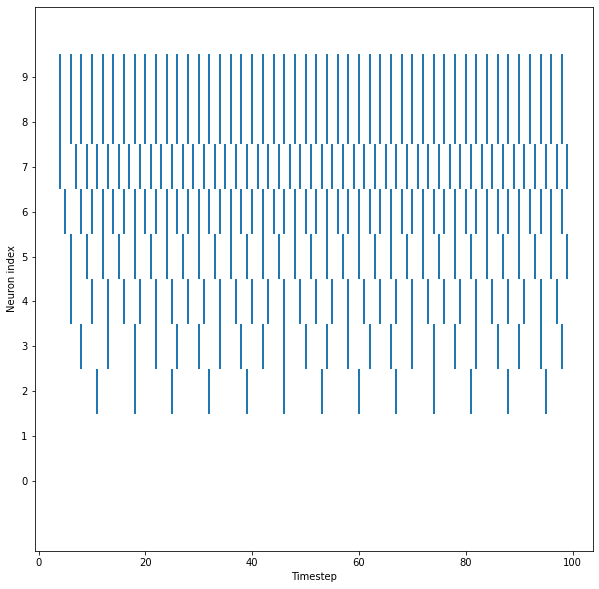

In [10]:
plt.figure(figsize=(10, 10))  # Set figure size 
plt.xlabel("Timestep")        # Label x axis
plt.ylabel("Neuron index")    # Label y axis
plt.yticks(list(range(10)))   # Force display all neuron indices
for i in range(10):           # Loop i from 0 to 9 (inclusive)
    plt.eventplot(spike_data) # Plot the timesteps where the neuron spiked

## Conclusion

And indeed, as expected neuron 0 did not fire. Nor did neuron 1. Neuron 8 and 9 however, received just the right amount of current for them to exhibit an identical firing pattern.

The power of the event-based paradigm is that this sparse behaviour can be exploited. If we look at the data over time, we can interpret this as if neuron 0 "talks less" than neuron 9. Meaning, it conveys less information.

In turn, this can be exploited in neural networks and learning (plasticity). That, however, is outside the scope of this tutorial.

## Additional resources

If you are interested in learning more, have a look [at our other notebooks](https://github.com/norse/norse/tree/master/notebooks) and [our documentation](https://norse.github.io/norse/).